In [72]:
%matplotlib inline
import pickle as pk
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [73]:
# Load data
file_path = Path("Resources/pickled_raws.pkl")
df = pd.read_pickle(file_path)
df.head()

,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,state_code,...,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,action_taken_summary,Region
respondent_id,,,,,,,,,,,,,,,,,,,,,
0000342634,CFPB,Conventional,One to Four-Family,Refinancing,Owner Occupied,9.0,Not Applicable,Application Denied by Financial Institution,33860.0,AL,...,Not a HOEPA Loan,Secured by a Subordinate Loan,1948.0,12.58,59700.0,122.93,507.0,724.0,0,SE
0004186591,CFPB,VA-Guaranteed,One to Four-Family,Home Purchase,Owner Occupied,94.0,Not Applicable,Loan Purchased by the Institution,33860.0,AL,...,Not a HOEPA Loan,Not Applicable (Purchased Loan),1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
22-3039688,HUD,VA-Guaranteed,One to Four-Family,Refinancing,Owner Occupied,161.0,Not Applicable,File Closed for Incompleteness,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,2,SE
20-3878295,NCUA,Conventional,One to Four-Family,Home Improvement,Owner Occupied,90.0,Not Applicable,Loan Originated,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
0000342634,CFPB,Conventional,One to Four-Family,Refinancing,Not Owner Occupied,41.0,Not Applicable,Loan Originated,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE


In [74]:
# Drop undesired columns
df = df.drop(columns=["action_taken", "purchaser_type", "denial_reason_1", "lien_status", "state_code", "hoepa_status"])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13997124 entries, 0000342634 to 0000510871
Data columns (total 25 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   agency_code                     object 
 1   loan_type                       object 
 2   property_type                   object 
 3   loan_purpose                    object 
 4   owner_occupancy                 object 
 5   loan_amount_000s                float64
 6   preapproval                     object 
 7   msamd                           float64
 8   county_code                     float64
 9   census_tract_number             float64
 10  applicant_ethnicity             object 
 11  co_applicant_ethnicity          object 
 12  applicant_race_1                object 
 13  co_applicant_race_1             object 
 14  applicant_sex                   object 
 15  co_applicant_sex                object 
 16  applicant_income_000s           float64
 17  population         

In [76]:
# Remove rows containing N/A, incomplete, or irrelevant information
df = df.loc[df["loan_purpose"] == "Home Purchase"]
df = df.drop(columns="loan_purpose")

In [77]:
df = df.loc[df["owner_occupancy"] != "Not Applicable"]

In [78]:
df = df.loc[df["applicant_sex"] != "Information not Provided"]
df = df.loc[df["applicant_sex"] != "Not Applicable"]

In [79]:
df = df.loc[df["co_applicant_sex"] != "Information not Provided"]
df = df.loc[df["co_applicant_sex"] != "Not Applicable"]

In [80]:
df = df.loc[df["applicant_ethnicity"] != "Not Applicable"]
df = df.loc[df["applicant_ethnicity"] != "Info not Provided by Applicant"]

In [81]:
df = df.loc[df["co_applicant_ethnicity"] != "Not Applicable"]
df = df.loc[df["co_applicant_ethnicity"] != "Info not Provided by Applicant"]

In [82]:
df = df.loc[df["preapproval"] != "Not Applicable"]

In [83]:
# Remove outlier homes
df = df.loc[df["loan_amount_000s"] <= 1650]

In [84]:
# Restrict target variable to only approvals and denials
df = df.loc[df["action_taken_summary"] != 2]

In [85]:
df.count()

agency_code                       1700356
loan_type                         1700356
property_type                     1700356
owner_occupancy                   1700356
loan_amount_000s                  1700356
preapproval                       1700356
msamd                             1700356
county_code                       1700356
census_tract_number               1700356
applicant_ethnicity               1700356
co_applicant_ethnicity            1700356
applicant_race_1                  1700356
co_applicant_race_1               1700356
applicant_sex                     1700356
co_applicant_sex                  1700356
applicant_income_000s             1700356
population                        1700356
minority_population               1700356
hud_median_family_income          1700356
tract_to_msamd_income             1700356
number_of_owner_occupied_units    1700356
number_of_1_to_4_family_units     1700356
action_taken_summary              1700356
Region                            

In [86]:
df.head()

,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,preapproval,msamd,county_code,census_tract_number,applicant_ethnicity,...,co_applicant_sex,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,action_taken_summary,Region
respondent_id,,,,,,,,,,,,,,,,,,,,,
0000233031,CFPB,FHA-Insured,One to Four-Family,Owner Occupied,92.0,Preapproval Requested,33860.0,1.0,201.0,Not Hispanic or Latino,...,No Co-Applicant,29.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
27-0349391,HUD,VA-Guaranteed,One to Four-Family,Owner Occupied,94.0,Preapproval Not Requested,33860.0,1.0,201.0,Not Hispanic or Latino,...,No Co-Applicant,53.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
63-1005978,HUD,FHA-Insured,One to Four-Family,Owner Occupied,147.0,Preapproval Not Requested,33860.0,1.0,201.0,Not Hispanic or Latino,...,Female,90.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
76-0503625,HUD,FHA-Insured,One to Four-Family,Owner Occupied,115.0,Preapproval Not Requested,33860.0,1.0,201.0,Not Hispanic or Latino,...,No Co-Applicant,30.0,1948.0,12.58,59700.0,122.93,507.0,724.0,0,SE
27-0349391,HUD,VA-Guaranteed,One to Four-Family,Owner Occupied,160.0,Preapproval Not Requested,33860.0,1.0,201.0,Not Hispanic or Latino,...,No Co-Applicant,50.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE


In [87]:
# Drop index
df = df.reset_index(drop=True)

In [88]:
# Generate our categorical variable lists
action_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df[action_cat].nunique()

agency_code               6
loan_type                 4
property_type             3
owner_occupancy           2
preapproval               2
applicant_ethnicity       2
co_applicant_ethnicity    3
applicant_race_1          6
co_applicant_race_1       7
applicant_sex             2
co_applicant_sex          3
Region                    7
dtype: int64

In [89]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[action_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(action_cat)
encode_df.head()

C:\Users\sherr\anaconda3\envs\ml2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agency_code_CFPB,agency_code_FDIC,agency_code_FRS,agency_code_HUD,agency_code_NCUA,agency_code_OCC,loan_type_Conventional,loan_type_FHA-Insured,loan_type_FSA/RHS,loan_type_VA-Guaranteed,...,co_applicant_sex_Female,co_applicant_sex_Male,co_applicant_sex_No Co-Applicant,Region_MA,Region_MW,Region_NE,Region_NW,Region_SE,Region_SW,Region_W
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
# Merge dummy columns and drop originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(action_cat, axis=1)
df.count()

loan_amount_000s                                                 1700356
msamd                                                            1700356
county_code                                                      1700356
census_tract_number                                              1700356
applicant_income_000s                                            1700356
population                                                       1700356
minority_population                                              1700356
hud_median_family_income                                         1700356
tract_to_msamd_income                                            1700356
number_of_owner_occupied_units                                   1700356
number_of_1_to_4_family_units                                    1700356
action_taken_summary                                             1700356
agency_code_CFPB                                                 1700356
agency_code_FDIC                                   

In [91]:
df.columns

Index(['loan_amount_000s', 'msamd', 'county_code', 'census_tract_number',
       'applicant_income_000s', 'population', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'action_taken_summary', 'agency_code_CFPB', 'agency_code_FDIC',
       'agency_code_FRS', 'agency_code_HUD', 'agency_code_NCUA',
       'agency_code_OCC', 'loan_type_Conventional', 'loan_type_FHA-Insured',
       'loan_type_FSA/RHS', 'loan_type_VA-Guaranteed',
       'property_type_Manufactured', 'property_type_Multifamily',
       'property_type_One to Four-Family',
       'owner_occupancy_Not Owner Occupied', 'owner_occupancy_Owner Occupied',
       'preapproval_Preapproval Not Requested',
       'preapproval_Preapproval Requested',
       'applicant_ethnicity_Hispanic or Latino',
       'applicant_ethnicity_Not Hispanic or Latino',
       'co_applicant_ethnicity_Hispanic or Latino',
       'co_applicant_

In [92]:
# Drop inverse columns for binary categories
df = df.drop(columns=["owner_occupancy_Not Owner Occupied", "applicant_sex_Male", "applicant_ethnicity_Not Hispanic or Latino", "preapproval_Preapproval Not Requested"])

In [93]:
# Define features and targets
y = df["action_taken_summary"]
X = df.drop(columns="action_taken_summary")

In [94]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

In [95]:
# Create StandardScaler instance, fit to X, scale
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [96]:
# Create a random forest classifier
model = RandomForestClassifier(max_depth = 3, max_features = 3, n_estimators=100, class_weight = "balanced", random_state=21)

In [97]:
# Fit model
model = model.fit(X_train_scaled, y_train)

In [98]:
predictions = model.predict(X_test_scaled)

In [99]:
# Calculate confusion matrix and accuracy score
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index= ["Actual 0", "Actual 1"], columns = ["Predicted 0", "Predicted 1"])

acc_score = accuracy_score(y_test, predictions)

In [100]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,29306,26485
Actual 1,127626,241672


Accuracy Score: 0.6374618021167332
              precision    recall  f1-score   support

           0       0.19      0.53      0.28     55791
           1       0.90      0.65      0.76    369298

    accuracy                           0.64    425089
   macro avg       0.54      0.59      0.52    425089
weighted avg       0.81      0.64      0.69    425089



In [101]:
# Sort features by importance
imp_list = sorted(zip(model.feature_importances_, X.columns), reverse=True)
imp_list

[(0.16489206980888138, 'applicant_income_000s'),
 (0.09767782542473963, 'loan_amount_000s'),
 (0.07447132317335141, 'applicant_race_1_White'),
 (0.07327095186704176, 'property_type_Manufactured'),
 (0.06735166902638444, 'property_type_One to Four-Family'),
 (0.06107359635128615, 'applicant_race_1_Black or African American'),
 (0.04707446940836147, 'tract_to_msamd_income'),
 (0.0464559767927396, 'co_applicant_race_1_White'),
 (0.044470625318693446, 'co_applicant_ethnicity_Not Hispanic or Latino'),
 (0.03786609808281781, 'minority_population'),
 (0.03536326200224052, 'co_applicant_ethnicity_No Co-Applicant'),
 (0.02846143626937825, 'Region_SE'),
 (0.028070369244134367, 'hud_median_family_income'),
 (0.024264834357691098, 'co_applicant_sex_Female'),
 (0.023120961901675882, 'loan_type_FHA-Insured'),
 (0.020370938819615176, 'agency_code_CFPB'),
 (0.013988960733241988, 'number_of_owner_occupied_units'),
 (0.013838915607180247, 'co_applicant_sex_No Co-Applicant'),
 (0.013294148573507431, 'msa

<AxesSubplot:>

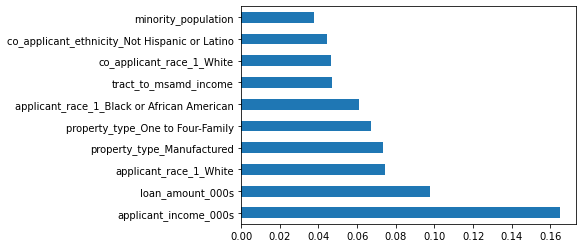

In [102]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')